In [57]:
import xarray as xr
from xarray import DataArray
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.io.img_tiles import OSM
from matplotlib.animation import FuncAnimation
import numpy as np
import pandas as pd

# Temperature index models

## Acknowledgment

by Thomas Gölles 2024

## Naive first approach

In [58]:
degree_day_factor = 8.0  # mm/day/degree celsius
temperature_plus = 3.0  # degree celsius
delta_time = 4  # day

melt = degree_day_factor * temperature_plus * delta_time
print(f"melt of snow for {delta_time} is {melt} mm")

melt of snow for 4 is 96.0 mm


Now lets look at the cumulative melt over 10 days

In [59]:
n = 11
days = range(1, n)
melt = 0

for day in days:
    melt = melt + degree_day_factor * temperature_plus * delta_time
    print(f"cummulative melt of snow for {day} is {melt:.2f} mm")

cummulative melt of snow for 1 is 96.00 mm
cummulative melt of snow for 2 is 192.00 mm
cummulative melt of snow for 3 is 288.00 mm
cummulative melt of snow for 4 is 384.00 mm
cummulative melt of snow for 5 is 480.00 mm
cummulative melt of snow for 6 is 576.00 mm
cummulative melt of snow for 7 is 672.00 mm
cummulative melt of snow for 8 is 768.00 mm
cummulative melt of snow for 9 is 864.00 mm
cummulative melt of snow for 10 is 960.00 mm


ok a bit nicer, but the Temperature is still constant. Now use a random tempearature list form -5 to +10

In [60]:
n = 11
days = range(1, n)

np.random.seed(42)
temperatures = np.random.uniform(-5, 10, len(days))
melt = 0

for day in days:
    temperature_plus = temperatures[day - 1]
    melt = melt + degree_day_factor * temperature_plus * delta_time
    print(
        f"cummulative melt of snow for {day} with {temperature_plus:.2f}°C is {melt:.2f} mm"
    )

cummulative melt of snow for 1 with 0.62°C is 19.78 mm
cummulative melt of snow for 2 with 9.26°C is 316.12 mm
cummulative melt of snow for 3 with 5.98°C is 507.48 mm
cummulative melt of snow for 4 with 3.98°C is 634.84 mm
cummulative melt of snow for 5 with -2.66°C is 549.72 mm
cummulative melt of snow for 6 with -2.66°C is 464.60 mm
cummulative melt of snow for 7 with -4.13°C is 332.48 mm
cummulative melt of snow for 8 with 7.99°C is 588.25 mm
cummulative melt of snow for 9 with 4.02°C is 716.78 mm
cummulative melt of snow for 10 with 5.62°C is 896.66 mm


In [61]:
n = 11
days = range(1, n)

np.random.seed(42)
temperatures = np.random.uniform(-5, 10, len(days))
melt = 0

for day in days:
    current_temperature = temperatures[day - 1]
    temperature_plus = np.maximum(current_temperature, 0)
    melt = melt + degree_day_factor * temperature_plus * delta_time
    print(
        f"cummulative melt of snow for {day} with {current_temperature:.2f}°C is {melt:.2f} mm"
    )

cummulative melt of snow for 1 with 0.62°C is 19.78 mm
cummulative melt of snow for 2 with 9.26°C is 316.12 mm
cummulative melt of snow for 3 with 5.98°C is 507.48 mm
cummulative melt of snow for 4 with 3.98°C is 634.84 mm
cummulative melt of snow for 5 with -2.66°C is 634.84 mm
cummulative melt of snow for 6 with -2.66°C is 634.84 mm
cummulative melt of snow for 7 with -4.13°C is 634.84 mm
cummulative melt of snow for 8 with 7.99°C is 890.60 mm
cummulative melt of snow for 9 with 4.02°C is 1019.14 mm
cummulative melt of snow for 10 with 5.62°C is 1199.01 mm


## Better use of Python

If you often reuse a culation but it in a function.
A function starts with "def" then the function name you want to have followed by the input argumetnts in ().

Here I also used so called typehints like degree_day_factor: float. Which means that we expect a floating point number as the degree day factor. In Python this optional but helps a lot in understanding what is expected.

Here I also give a default value of the threshold_temp. This means that if no third argument is given the standard value of 0.0 is used.

In [62]:
def degree_day_model(
    temperatures: np.ndarray | DataArray,
    degree_day_factor: float,
    threshold_temp: float = 0.0,
) -> np.ndarray | DataArray:
    """
    Estimate daily melt amount using the Degree-Day Model.

    Parameters:
    temperatures (numpy.array): Array of daily mean air temperatures (°C).
    degree_day_factor (float): Degree-day factor (mm °C^-1 day^-1).
    threshold_temp (float): Threshold temperature above which melting occurs (°C). Default is 0.0°C.

    Returns:
    numpy.array: Array of daily melt amounts (mm).
    """
    # Calculate positive temperature differences (temperatures above the threshold)
    positive_temperatures = np.maximum(temperatures - threshold_temp, 0)

    # Calculate daily melt amounts
    daily_melt = positive_temperatures * degree_day_factor

    return daily_melt

In [63]:
temperatures = np.array([-3.2, -1.1, 0.0, 2.2, 5.1, 3.0, 0.0, -2.0])

In [64]:
ddf = 8.0
melt_amounts = degree_day_model(temperatures, degree_day_factor=ddf)
melt_amounts

array([ 0. ,  0. ,  0. , 17.6, 40.8, 24. ,  0. ,  0. ])

note here we used the default value for threshold_temp.
So the result is an array of values correspondig to daily temperatures.
To make it nicer to work with lets make a pandas dataframe together with the temperatures

In [65]:
from operator import index


melt = pd.DataFrame(
    melt_amounts,
    index=temperatures,
    columns=[f"melt (mm)"],
)
melt.index.name = "Temperature (°C)"
melt

,melt (mm)
Temperature (°C),
-3.2,0.0
-1.1,0.0
0.0,0.0
2.2,17.6
5.1,40.8
3.0,24.0
0.0,0.0
-2.0,0.0


<Axes: xlabel='Temperature (°C)'>

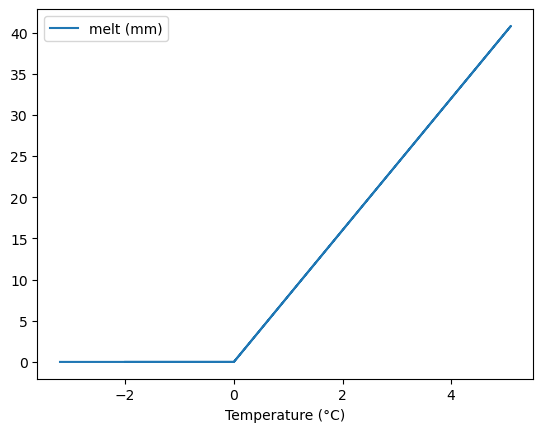

In [66]:
melt.plot()

### Exersize

* plot the curve for different degree day factors.
* compare snow and ice: 2.5 to 11.6 mm/(day K)  for snow 6.6 to 20.0 mm/(day K) for ice,
* change the function to use SI base units

What is the total amount of melt in mm over all days

In [67]:
melt["melt (mm)"].sum()

82.4

## Spatial distributed version

We take actual weather data from geosphere over the Pasterze region.

![INCA data auschnitt](figures/Pasterze.png)

Load the netcdf dataset

In [68]:
inca_pasterze = xr.open_dataset("data/inca_pasterze.nc")

In [69]:
inca_pasterze

<xarray.Dataset>
Dimensions:                  (time: 192, y: 9, x: 8)
Coordinates:
    lambert_conformal_conic  float64 ...
    lat                      (y, x) float32 ...
    lon                      (y, x) float32 ...
  * time                     (time) datetime64[ns] 2023-07-01 ... 2023-07-08T...
  * x                        (x) int32 349000 350000 351000 ... 355000 356000
  * y                        (y) int32 352000 353000 354000 ... 359000 360000
Data variables:
    T2M                      (time, y, x) float32 ...
    GL                       (time, y, x) float64 ...
    P0                       (time, y, x) float64 ...
    RH2M                     (time, y, x) float32 ...
    RR                       (time, y, x) float64 ...
    TD2M                     (time, y, x) float32 ...
    UU                       (time, y, x) float32 ...
    VV                       (time, y, x) float32 ...
Attributes: (12/14)
    Conventions:         CF-1.7
    author:              Alexander Kann (alexander.kann@zamg.ac.at), Benedikt...
    comment:             No additional comments
    crs:                 EPSG:31287
    freq:                1H
    grid_mapping:        lambert_conformal_conic
    ...                  ...
    name:                incal-hourly
    references:          https://www.zamg.ac.at/cms/de/forschung/wetter/inca ...
    source:              modeled data
    spatial_domain:      INCAL
    spatial_resolution:  1000
    title:               INCA analysis - large domain

take onhly the Tempearature at 2 meter varaible called T2M, for one hour to get the spatial extend. 
Note the dimensions. Ther are 192 time sclices and 9 points in y and 8 points in x direction.
The INCA dataset has a resolutution of 1x1 km. Which also determines the resolution on which we can calculate the melt.

IMPORTANT: Since our model expects Day as the time unit we need to be carefull and take daily averages. Always think about the units of input and outputs!

In [70]:
# Compute daily averages
daily_averages = inca_pasterze.resample(time="1D").mean()

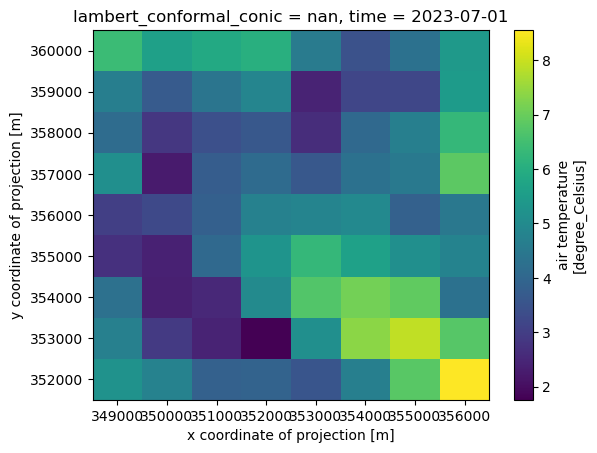

In [71]:
temperatures = daily_averages["T2M"]
temperature_example = temperatures.sel(time="2023-07-01T00:00:00")
temperature_example.plot()

In [72]:
type(temperature_example)

xarray.core.dataarray.DataArray

In [73]:
melt_amounts_distributed = degree_day_model(temperature_example, degree_day_factor=ddf)
melt_amounts_distributed.name = "melt per day (mm)"

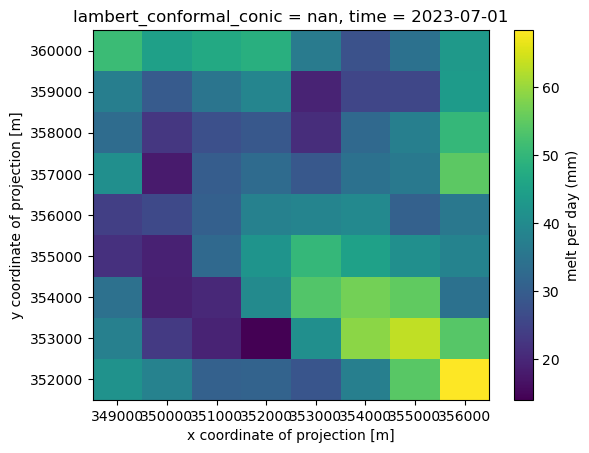

In [74]:
melt_amounts_distributed.plot()

## Now with space and time

We have data over 8 days lets see the resulting melt

In [75]:
tempeartures = daily_averages["T2M"]
tempeartures

<xarray.DataArray 'T2M' (time: 8, y: 9, x: 8)>
array([[[ 5.2320833 ,  4.744166  ,  3.8324995 ,  3.8950002 ,
          3.562917  ,  4.662916  ,  6.800833  ,  8.552917  ],
        [ 4.684583  ,  2.9120836 ,  2.4079168 ,  1.7600002 ,
          5.1283326 ,  7.3808327 ,  7.902916  ,  6.7712502 ],
        [ 4.2599998 ,  2.3670833 ,  2.5079165 ,  4.9883337 ,
          6.710833  ,  7.1175003 ,  6.8970833 ,  4.2983336 ],
        [ 2.6966667 ,  2.3833334 ,  4.0554166 ,  5.277083  ,
          6.2754154 ,  5.6145825 ,  5.122083  ,  4.809583  ],
        [ 3.010416  ,  3.2558334 ,  3.819583  ,  4.725833  ,
          4.8220835 ,  4.965417  ,  3.8308327 ,  4.4700003 ],
        [ 5.12875   ,  2.2549999 ,  3.7445831 ,  4.105833  ,
          3.6145833 ,  4.2954164 ,  4.5016665 ,  6.840834  ],
        [ 4.1441665 ,  2.83      ,  3.4183333 ,  3.5966666 ,
          2.622917  ,  4.0487504 ,  4.6683335 ,  6.2712502 ],
        [ 4.628333  ,  3.6808329 ,  4.397084  ,  4.8450003 ,
          2.418333  ,  3.1699994 ,  3.1941664 ,  5.4725    ],
        [ 6.382916  ,  5.589583  ,  5.8579164 ,  6.037083  ,
          4.5524993 ,  3.4749997 ,  4.302917  ,  5.3999996 ]],

       [[ 5.502083  ,  4.9925003 ,  4.207083  ,  4.3549995 ,
...

       [[ 7.6104164 ,  6.9408326 ,  5.8650002 ,  5.9745827 ,
          5.587916  ,  7.00125   ,  9.678334  , 12.09625   ],
        [ 7.0870833 ,  4.8016667 ,  4.1525    ,  3.2512496 ,
          7.5695825 , 10.664999  , 11.492082  , 10.025833  ],
        [ 6.7137504 ,  4.205416  ,  4.3804164 ,  7.5541663 ,
          9.98125   , 10.574165  , 10.254582  ,  6.7554173 ],
        [ 4.7358327 ,  4.339584  ,  6.450834  ,  8.273749  ,
          9.674167  ,  8.957499  ,  8.005417  ,  7.6208344 ],
        [ 5.2074995 ,  5.5737495 ,  6.1745834 ,  7.3824997 ,
          7.542917  ,  7.9433327 ,  6.2237506 ,  7.2029157 ],
        [ 8.519583  ,  4.2212496 ,  6.304584  ,  6.5324993 ,
          6.0558333 ,  7.02      ,  7.2791667 , 11.0512495 ],
        [ 6.98      ,  5.045833  ,  5.859999  ,  6.060833  ,
          4.6870837 ,  6.7075005 ,  7.6183333 , 10.209167  ],
        [ 7.8350005 ,  6.26125   ,  7.417917  ,  7.848333  ,
          4.450416  ,  5.4979157 ,  5.4950004 ,  8.992499  ],
        [10.245833  ,  9.197915  ,  9.334167  ,  9.605832  ,
          7.6625    ,  5.9962497 ,  7.187916  ,  8.961667  ]]],
      dtype=float32)
Coordinates:
    lambert_conformal_conic  float64 nan
    lat                      (y, x) float32 47.07 47.07 47.07 ... 47.14 47.14
    lon                      (y, x) float32 12.66 12.67 12.69 ... 12.74 12.75
  * x                        (x) int32 349000 350000 351000 ... 355000 356000
  * y                        (y) int32 352000 353000 354000 ... 359000 360000
  * time                     (time) datetime64[ns] 2023-07-01 ... 2023-07-08
Attributes:
    cell_method:     
    description:     air temperature 2m above ground
    esri_pe_string:  PROJCS["MGI / Austria Lambert",GEOGCS["MGI",DATUM["Milit...
    grid_mapping:    lambert_conformal_conic
    long_name:       air temperature
    standard_name:   surface_temperature
    units:           degree_Celsius

The original

In [76]:
melt_result = degree_day_model(temperatures, degree_day_factor)
melt_result.name = "melt (mm)"

In [77]:
melt_result

<xarray.DataArray 'melt (mm)' (time: 8, y: 9, x: 8)>
array([[[41.856667  , 37.953327  , 30.659996  , 31.160002  ,
         28.503336  , 37.30333   , 54.406666  , 68.42333   ],
        [37.476665  , 23.296669  , 19.263334  , 14.080002  ,
         41.02666   , 59.04666   , 63.223328  , 54.170002  ],
        [34.079998  , 18.936666  , 20.063332  , 39.90667   ,
         53.686665  , 56.940002  , 55.176666  , 34.38667   ],
        [21.573334  , 19.066668  , 32.443333  , 42.216663  ,
         50.203323  , 44.91666   , 40.976665  , 38.476665  ],
        [24.083328  , 26.046667  , 30.556664  , 37.806664  ,
         38.576668  , 39.723335  , 30.646662  , 35.760002  ],
        [41.03      , 18.039999  , 29.956665  , 32.846664  ,
         28.916666  , 34.36333   , 36.013332  , 54.726673  ],
        [33.15333   , 22.64      , 27.346666  , 28.773333  ,
         20.983335  , 32.390003  , 37.34667   , 50.170002  ],
        [37.026665  , 29.446663  , 35.176674  , 38.760002  ,
         19.346664  , 25.359995  , 25.553331  , 43.78      ],
        [51.063328  , 44.716663  , 46.86333   , 48.296665  ,
         36.419994  , 27.799997  , 34.423336  , 43.199997  ]],

       [[44.016663  , 39.940002  , 33.656666  , 34.839996  ,
...

       [[60.88333   , 55.52666   , 46.920002  , 47.79666   ,
         44.703327  , 56.01      , 77.426674  , 96.77      ],
        [56.696667  , 38.413334  , 33.22      , 26.009996  ,
         60.55666   , 85.31999   , 91.93665   , 80.206665  ],
        [53.710003  , 33.64333   , 35.04333   , 60.43333   ,
         79.85      , 84.59332   , 82.03666   , 54.04334   ],
        [37.88666   , 34.71667   , 51.60667   , 66.189995  ,
         77.39333   , 71.65999   , 64.043335  , 60.966675  ],
        [41.659996  , 44.589996  , 49.396667  , 59.059998  ,
         60.343334  , 63.54666   , 49.790005  , 57.623325  ],
        [68.15666   , 33.769997  , 50.436672  , 52.259995  ,
         48.446667  , 56.16      , 58.233334  , 88.409996  ],
        [55.84      , 40.366665  , 46.879993  , 48.486664  ,
         37.49667   , 53.660004  , 60.946667  , 81.67333   ],
        [62.680004  , 50.09      , 59.343334  , 62.786663  ,
         35.60333   , 43.983326  , 43.960003  , 71.939995  ],
        [81.96667   , 73.58332   , 74.67333   , 76.84666   ,
         61.3       , 47.969997  , 57.503326  , 71.69334   ]]],
      dtype=float32)
Coordinates:
    lambert_conformal_conic  float64 nan
    lat                      (y, x) float32 47.07 47.07 47.07 ... 47.14 47.14
    lon                      (y, x) float32 12.66 12.67 12.69 ... 12.74 12.75
  * x                        (x) int32 349000 350000 351000 ... 355000 356000
  * y                        (y) int32 352000 353000 354000 ... 359000 360000
  * time                     (time) datetime64[ns] 2023-07-01 ... 2023-07-08

Thats the result. Now we can plot and animate the result.

Basically this an open street map as a background and then makes a plot for each timestep. The result is then saved as gif.
It takes about a minute to run.

**WARNING Do not run this below on binder, it takes up to much memory.**

MovieWriter ffmpeg unavailable; using Pillow instead.


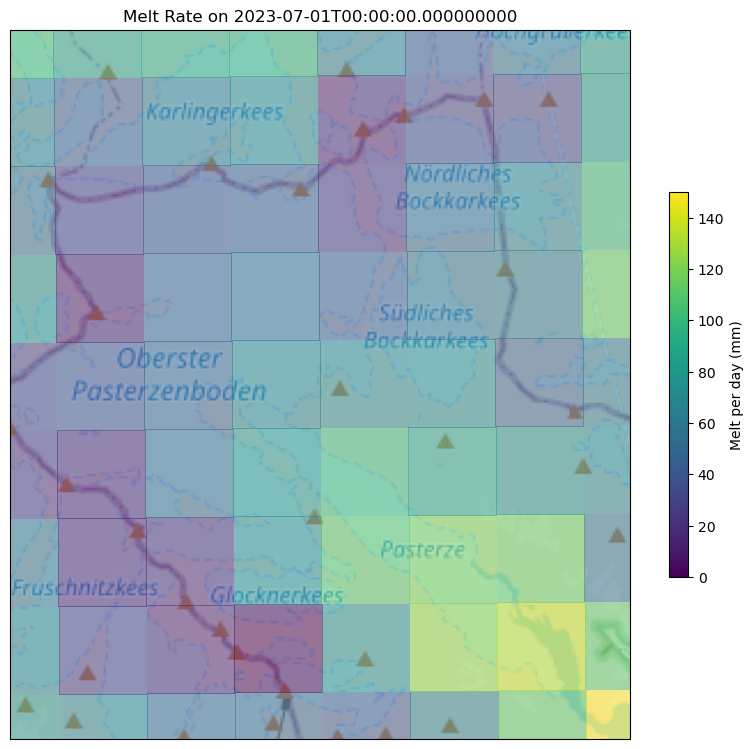

In [78]:
# Initialize the figure
fig = plt.figure(figsize=(10, 10))
osm_tiles = OSM()
ax = plt.axes(projection=osm_tiles.crs)
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS, linestyle=":")

# Pre-calculate extent to avoid recalculating it each frame
lat_min, lat_max = np.min(melt_result.lat.values), np.max(melt_result.lat.values)
lon_min, lon_max = np.min(melt_result.lon.values), np.max(melt_result.lon.values)
ax.set_extent([lon_min, lon_max, lat_min, lat_max], crs=ccrs.PlateCarree())

# Add base map once (assumes all slices have similar extents)
ax.add_image(osm_tiles, 12)

# Prepare colorbar (setup with dummy data)
sm = plt.cm.ScalarMappable(cmap="viridis", norm=plt.Normalize(vmin=0, vmax=150))
sm._A = []  # dummy data for ScalarMappable
cbar = plt.colorbar(sm, ax=ax, shrink=0.5, aspect=20, label="Melt per day (mm)")


# The update function for the animation
previous_collections = []  # Store previous plot references


def update(frame):
    global previous_collections  # Refer to the global list
    # Remove previous collections
    for collection in previous_collections:
        collection.remove()
    previous_collections.clear()  # Clear the list after removal

    data_slice = melt_result.isel(time=frame)
    time_str = str(data_slice.time.values)
    new_collection = ax.pcolormesh(
        data_slice.lon,
        data_slice.lat,
        data_slice.values,
        transform=ccrs.PlateCarree(),
        cmap="viridis",
        alpha=0.5,
    )
    previous_collections.append(new_collection)  # Add new plot to the list
    ax.set_title(f"Melt Rate on {time_str}")


# Create animation
ani = FuncAnimation(fig, update, frames=len(melt_result.time), interval=200)

ani.save("figures/melt_rate_animation.gif", dpi=300)